# TP: MNIST with Neural Networks (NN)

Students:
Leonel Mota Sampaio Durão
Luiz Augusto Facury de Souza

In [1]:
import numpy as np
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

2023-04-07 16:39:47.444960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 16:39:47.703445: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-07 16:39:47.703476: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-07 16:39:48.440172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Using tensorflow version 2.11.0
Using keras version 2.11.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [2]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

<div class='alert alert-block alert-info'>
            Code:</div>

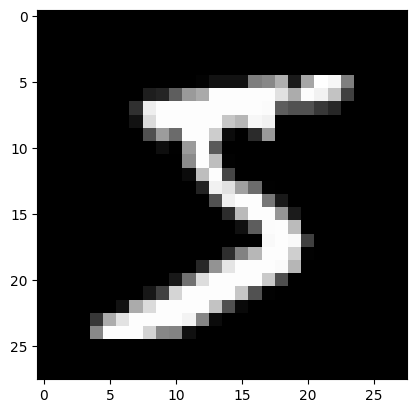

In [3]:
# Let us visualize the first training sample using the Matplotlib library with the imshow function
from matplotlib import pyplot as plt
plt.imshow(train_images[0], cmap='gray')
plt.show()


The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

<div class='alert alert-block alert-info'>
            Code:</div>

In [4]:
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print (train_labels)
print (test_labels)


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

<div class='alert alert-block alert-info'>
            Code:</div>

In [5]:
# Reshape images to vectors of pixels
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape(train_images.shape[0], img_rows * img_cols)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1] * test_images.shape[2])


# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
train_images = (train_images - np.mean(train_images)) / np.std(train_images)
test_images = (test_images - np.mean(train_images)) / np.std(train_images)

# First part: working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

### Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.
<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """

    
    # Create W at the right size with a normal distribution
    W = np.random.randn(n_input, n_output) * 0.01
    # Create b at the right size, with zeros
    b = np.zeros((1, n_output))
    nb_params = n_input * n_output + n_output
    return W, b, nb_params

In [7]:
n_training = train_images.shape[0] 
n_feature = train_images.shape[1] 
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """

    z = np.dot(X, W) + b

    return z

### Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 
<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    
    out = np.exp(z-np.max(z,1,keepdims=True)) / np.sum(np.exp(z-np.max(z,1,keepdims=True)), axis=1, keepdims=True)
    return out

### Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} + \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$
**Remark**: Careful, the usual way of implementing this in python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} + \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        return param - eta*grad_param
    elif regularizer=='L2':
        return param - eta * (grad_param + weight_decay * param)
    else:
        raise NotImplementedError

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function: <div class='alert alert-block alert-info'>
            Code:</div>

In [11]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    #print (grad.shape)
    #print (X.shape)
    grad_w = np.dot(X.T, grad)
    grad_b = np.sum(grad, axis=0, keepdims=True)
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

### Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.
<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    # Forward propagation
    z = forward(W, b, X)
 
    # Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(out, axis=1)
    
    # Compute the accuracy
    accuracy = np.mean(pred == np.argmax(labels, axis=1))
      
    return accuracy

### Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each training example once. 

In [13]:
# Optimization
eta = 0.002
regularizer = "L2"
weight_decay = 0.0001

# Training
log_interval = 1000

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

#######################
### Learning process ##
#######################
print(test_labels.shape, test_images.shape)
for j in range(n_training):
    # Getting the example
    X, y = train_images[j], train_labels[j]
    X = X.reshape((1, -1))
    y = y.reshape((1, -1))
    #print(X.shape, y.shape, b.shape, W.shape)
 
    # Forward propagation
    z = forward(W, b, X)

    # Compute the softmax
    out = softmax(z)
        
    # Compute the gradient at the top layer
    derror = out - y # This is o - y 

    # Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        # Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels) 

        # And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        #result_line = str(int(j)) + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
        #print(result_line)

g_train_acc.append(train_accuracy)
#print(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = "Final result:" + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
print(result_line)     

(10000, 10) (10000, 784)
Final result: 0.90955 0.8082 0.002


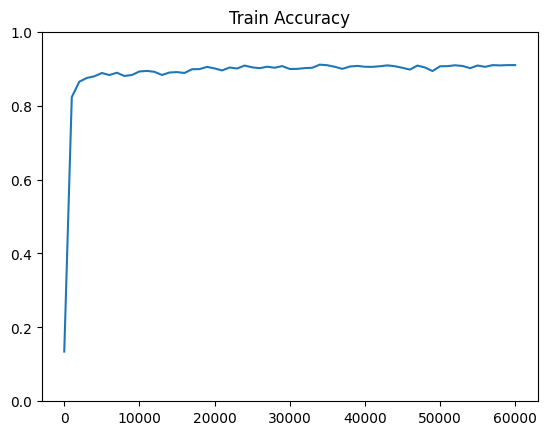

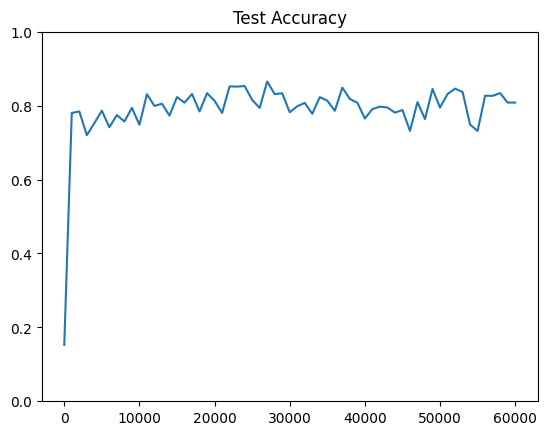

In [15]:
plt.plot(np.arange(0, n_training+1, log_interval), g_train_acc)
plt.ylim(0, 1)
plt.title("Train Accuracy")
plt.show()
plt.plot(np.arange(0, n_training+1, log_interval), g_valid_acc)
plt.ylim(0, 1)
plt.title("Test Accuracy")
plt.show()

What can you say about the performance of this simple linear classifier ?

Answer: The classifier achieved around 0.9 in training accuracy and 0.8 in test accuracy. This result is surprising since this model is rather simple and it can classify accurately most of the time the classes of the images, which are a more complex dataset and not obviously linearly separable. Each digit can be written in very different ways and the model achived good results event with few training images.

# Second part: Autoencoder with Keras

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:
<div class='alert alert-block alert-info'>
            Code:</div>

Text(0.5, 0, 'Second Principal Component')

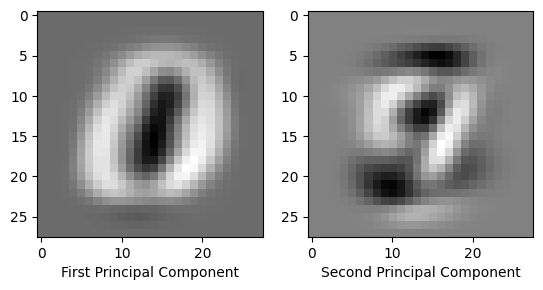

In [16]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components=num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape(num_components, 28, 28)

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')

In [17]:
# Print the variance explained by those components
pca.explained_variance_

array([53.901344, 39.41193 ], dtype=float32)

Comment on the visualization in relation to the variance explained by only keeping the two principal components:
<div class='alert alert-block alert-warning'>
            Answer:</div>

We can see that the visualization makes sense, the first PC tries to capture the round parts, as we can see clearly the 0, while the second PC gets other details, such as the 9 and 1. The explained variance is very high, so the first two dimensinos explain 53.9 + 39.4 =93.3% of the data.

### Implementing the Autoencoder with Keras

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
# Input layer
input_layer = Input(shape=(784,), name='input_layer')

# Encoding layer
latent_view = Dense(2, activation='relu', name='latent_view')(input_layer)

# Decoding layer
output_layer = Dense(784, activation='sigmoid', name='output_layer')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 latent_view (Dense)         (None, 2)                 1570      
                                                                 
 output_layer (Dense)        (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


2023-04-07 16:40:18.568084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-07 16:40:18.568125: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-07 16:40:18.568143: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ManjaroLuizf): /proc/driver/nvidia/version does not exist
2023-04-07 16:40:18.568376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [20]:
from tensorflow.keras.losses import MeanSquaredError

loss = MeanSquaredError()

optimizer = SGD(learning_rate=0.1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images, train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 1s 3ms/step - loss: 1.1848 - val_loss: 7359.1704
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.8164 - val_loss: 7358.9287
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.8011 - val_loss: 7359.0830
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7986 - val_loss: 7358.9546
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7946 - val_loss: 7357.0137
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7837 - val_loss: 7355.3198
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7703 - val_loss: 7354.7534
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7622 - val_loss: 7354.4927
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7572 - val_loss: 7354.3286
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [21]:
weights, bias = ae_model.get_layer('latent_view').get_weights()

<div class='alert alert-block alert-info'>
            Code:</div>

Text(0.5, 0, 'Second Dimension')

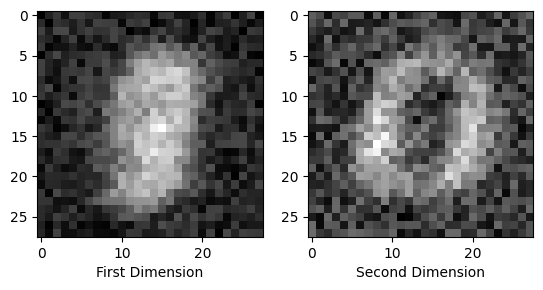

In [22]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
f, ax = plt.subplots(1,2)
ax[0].imshow(weights[:,0].reshape(28,28), cmap='gray')
ax[0].set_xlabel('First Dimension')
ax[1].imshow(weights[:,1].reshape(28,28), cmap='gray')
ax[1].set_xlabel('Second Dimension')


Now, visualize the images rebuilt by the network !
<div class='alert alert-block alert-info'>
            Code:</div>

1/1 [==============================] - 0s 13ms/step


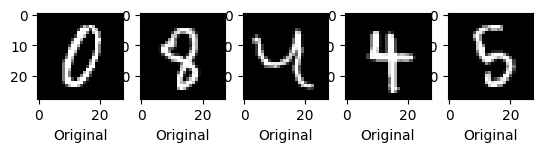

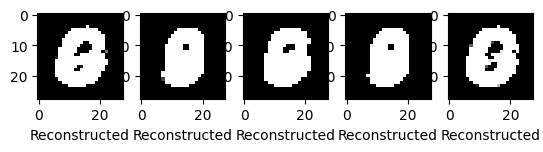

In [23]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Original')
    
# Get the prediction from the model 


# ... and plot them 
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(history.model.predict(test_images[a].reshape(1,784)).reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Reconstructed')

Testing with just 2 dimensions for the representation, we can see that the plot of the dimensions of the encoder, in a similar manner to the principal components makes sense, it resembles the numbers. However, the reconstruction is not a good at all, so we would have to increase the number of dimensions in the representation in order to have a better reconstruction.

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [24]:
# Input layer
input_layer = Input(shape=(784,), name='input_layer')

# Encoding layer
latent_view = Dense(500, activation='relu', name='latent_view')(input_layer)

# Decoding layer
output_layer = Dense(784, activation='sigmoid', name='output_layer')(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

from tensorflow.keras.losses import MeanSquaredError

loss = MeanSquaredError()

optimizer = SGD(learning_rate=0.1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images, train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))


Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 latent_view (Dense)         (None, 500)               392500    
                                                                 
 output_layer (Dense)        (None, 784)               392784    
                                                                 
Total params: 785,284
Trainable params: 785,284
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 3s 7ms/step - loss: 0.8660 - val_loss: 7353.9702
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.7196 - val_loss: 7351.1162
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6719 - val_loss: 7350.0586
Epoch 4

1/1 [==============================] - 0s 17ms/step


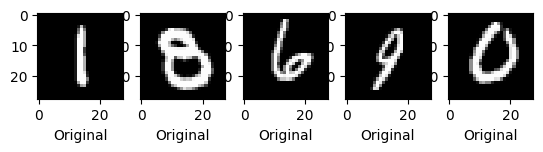

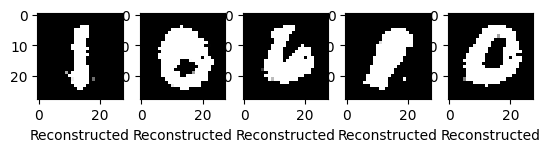

In [25]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Original')
    
# Get the prediction from the model 


# ... and plot them 
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(history.model.predict(test_images[a].reshape(1,784)).reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Reconstructed')

### Bonus: De-noising Autoencoder

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built.

In [26]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

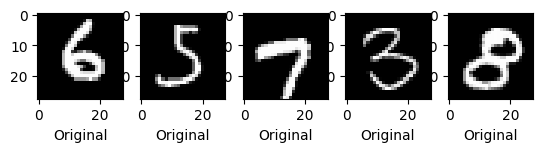

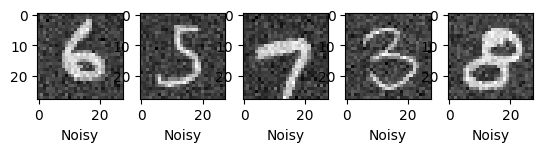

In [27]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)
#print first 5 noisy vs normal images
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(train_images[a].reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Original')
plt.show()
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(noisy_train_images[a].reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Noisy')

<div class='alert alert-block alert-info'>
            Code:</div>

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 latent_view1 (Dense)        (None, 500)               392500    
                                                                 
 latent_view2 (Dense)        (None, 300)               150300    
                                                                 
 latent_view3 (Dense)        (None, 50)                15050     
                                                                 
 output_layer1 (Dense)       (None, 300)               15300     
                                                                 
 output_layer2 (Dense)       (None, 500)               150500    
                                                                 
 output_layer3 (Dense)       (None, 784)               392

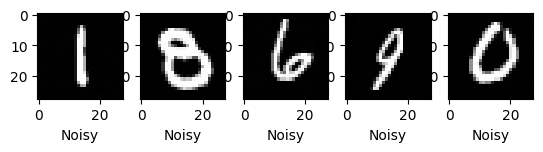

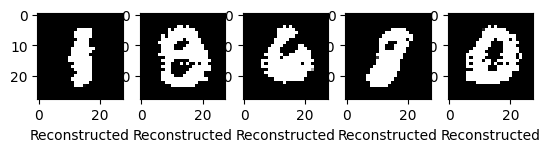

In [28]:
# Visualize some of the images with noise against the originals
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(noisy_test_images[a].reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Noisy')

# Build a new model with more layers and Relu activations
# Input layer
input_layer = Input(shape=(784,), name='input_layer')

# Encoding layer
latent_view1 = Dense(500, activation='relu', name='latent_view1')(input_layer)
latent_view2 = Dense(300, activation='relu', name='latent_view2')(latent_view1)
latent_view3 = Dense(50, activation='relu', name='latent_view3')(latent_view2)

# Decoding layer
output_layer1 = Dense(300, activation='relu', name='output_layer1')(latent_view3)
output_layer2 = Dense(500, activation='relu', name='output_layer2')(output_layer1)
output_layer3 = Dense(784, activation='sigmoid', name='output_layer3')(output_layer2)

ae_model = Model(input_layer, output_layer3, name='ae_model')
ae_model.summary()
loss = MeanSquaredError()

optimizer = SGD(learning_rate=0.1)



# Compile it but here, use noised data as inputs !
ae_model.compile(optimizer=optimizer, loss=loss)

batch_size = 128
epochs = 10
history = ae_model.fit(noisy_train_images, train_images,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=1,
                          shuffle=True,
                          validation_data=(noisy_test_images, test_images))



# Visualize the images rebuilt by the model !
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(history.model.predict(noisy_test_images[a].reshape(1,784)).reshape(28,28), cmap='gray')
    ax[i].set_xlabel('Reconstructed')


We can observe that the reconstructed images are less noisier than the ones predicted previously. However, it is not very stable and sometimes it changes the shape of the images. Besides, the archtecture of the network has a high effect on the performance, so it could be improved with more time and hyperparameter optmization.

Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?
<div class='alert alert-block alert-warning'>
            Answer:</div>

Considering that the images are binary, we could use binary cross-entropy as a loss, it measures the dissimilarity between the predicted and labeled images.